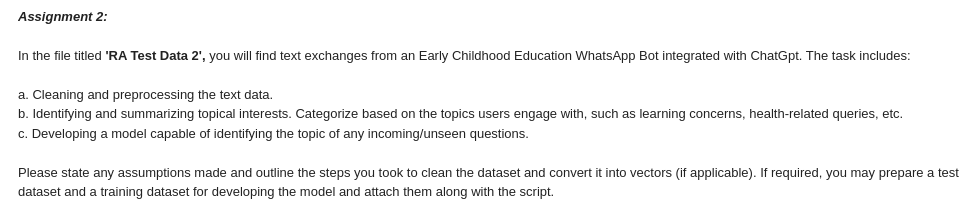

Approach: Lets identify the topics first based on the response text and create a new label column. Afterward with the question column and label column we can build a ML model!

>[Imports](#scrollTo=lELEZfoGHNta)

>[Get the data](#scrollTo=AVSYKgz9HIu-)

>[Data Cleaning and Preprocessing](#scrollTo=rfBpL9LGI-5n)

>>[Text preprocessing](#scrollTo=CwKIMNOxp14e)

>>[Lets check if the text_response column contains any NaN values after our cleaning operation](#scrollTo=1_3FHKTKRB9u)

>>[Word Cloud Vizualization](#scrollTo=2FtyoBLSqH2V)

>[Topic Modelling](#scrollTo=m3KYq8dQav9j)

>>[LDA](#scrollTo=0u6dJPdErULy)

>>[Hyperparameter tuning](#scrollTo=MblQq37bx8kP)

>[ML Model Development for predicting the topic of the question](#scrollTo=s3mF4f2mRDFJ)

>>[Sklearn Import needed for this section](#scrollTo=fl1XmeokRhi5)

>>[Data preprocessing and cleaning](#scrollTo=BpeqhNfbR5V_)

>>[check the dataimbalance](#scrollTo=I6E3IwvlTERn)

>>[seperate the X and Y label](#scrollTo=QTs3ztj4T4ex)

>>[TFIDF Vectorizer:](#scrollTo=zMzY3lEoUL6U)

>>[Handling imbalance in the dataset:](#scrollTo=fV9-fUZTWUNA)

>>[Train test split](#scrollTo=aqdpR2v6WY_I)

>>[Building Multiclass classification model](#scrollTo=hvSdomehXMme)

>>>[model evaluator](#scrollTo=81X95mlCYi2o)

>>>[Baseline Model](#scrollTo=ktwsWEj0X6Be)

>>>[Logistic Regression](#scrollTo=qzr9y1_rZgcl)

>>>>[Hyperparameter tuning](#scrollTo=YAaI4mkGZ5vg)

>>>[Bagging](#scrollTo=l9d4Iu90fxY4)

>>>[LinearSVC](#scrollTo=VEhiRTYPfibU)

>>>>[hyperparameter tuning](#scrollTo=Y0bdGTK_gQEK)

>>>[Results](#scrollTo=XOPh4uzkjjGR)



# 1. Imports

In [1]:
# Install the libraries >> Comment this section >> Restart the session
# !pip install pyLDAvis

In [2]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# import regex module
import re

# display all the columns in dataframe
pd.set_option('display.max_columns', None)

# import spacy
import spacy

# Gensim
import gensim

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Phrases
from pprint import pprint
from gensim import corpora, models

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#global matplotlib settings
mpl.rc('figure',figsize=(8,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# import seaborn
import seaborn as sns

import warnings
# Ignore all warnings (like convergence..) by sklearn
def warn(*args, **kwargs):
  pass
warnings.warn = warn


## import wordcloud
from wordcloud import WordCloud

## imports from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 1. Get the data

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/aps0611/pratham_research/main/raw/RA%20TestData%202.csv")
data.head(5)

,chat_id,question_translated,text_response
0,1000,What is NCF?,The National ECCE Curriculum Framework is a do...
1,1014,The girl has diarrhoea,Here is a resource link for a video in Hindi t...
2,1021,My child has a fever. What do I do?,"If your child has a fever, it is important to ..."
3,1022,Yes it is,"As an AI language model, my policy is to provi..."
4,1023,My child has a fever. What do I do?,"If your child has a fever, it is important to ..."


In [5]:
data.shape

(927, 3)

In [6]:
data.chat_id.value_counts()

chat_id
654     2
700     2
720     2
719     2
718     2
       ..
1830    1
1831    1
1832    1
1834    1
999     1
Name: count, Length: 830, dtype: int64

In [7]:
data[data.chat_id == 654]

,chat_id,question_translated,text_response
655,654,Children need to be fed outside.,"Unfortunately, none of the provided context me..."
656,654,Suggest some videos to develop language skills...,Here are some videos that can help develop lan...


In [8]:
data.question_translated.value_counts()

question_translated
What is the National Curriculum Framework for ece?                    39
What's Stunning                                                       17
What is Early Childhood Education?                                    14
1                                                                     11
My child has diarrhea What should I do?                               11
                                                                      ..
My son's hands are very thin                                           1
My daughter is having trouble with her period, suggest a solution.     1
My son is angry.                                                       1
My child is suffering from constipation                                1
T                                                                      1
Name: count, Length: 606, dtype: int64

# 2. Data Cleaning and Preprocessing

In [9]:
df = data.copy()

In [10]:
# check if there are any nan values

df.isna().sum()

chat_id                0
question_translated    0
text_response          0
dtype: int64

## Text preprocessing

In [11]:
## lets get the list of stop words from public github repo
## https://github.com/stanfordnlp/CoreNLP/blob/main/data/edu/stanford/nlp/patterns/surface/stopwords.txt
my_stop_words = [
    "!!", "?!", "??", "!?", "`", "``", "''", "-lrb-", "-rrb-", "-lsb-", "-rsb-",
    ",", ".", ":", ";", '"', "'", "?", "<", ">", "{", "}", "[", "]", "+", "-",
    "(", ")", "&", "%", "$", "@", "!", "^", "#", "*", "..", "...",
    "ll", "s", "'m", "a", "about", "above", "after", "again", "against", "all",
    "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
    "before", "being", "below", "between", "both", "but", "by", "can",
    "could", "did",
    "doing", "down", "during", "each", "for", "from", "further",
    "had", "has", "have", "having", "he", "hed",
    "hell", "hes", "her", "here", "heres", "hers", "herself", "him", "himself",
    "his", "how", "hows", "i", "id", "ill", "im", "ive", "if", "in", "into",
    "is", "it", "its", "itself", "lets", "me", "more", "most",
    "my", "myself","nor", "of", "on", "only",
    "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same",
    "shant", "she", "shed", "shell", "shes", "should", "shouldnt", "so", "some",
    "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves",
    "then", "there", "theres", "these", "they", "theyd", "theyll", "theyre",
    "theyve", "this", "those", "through", "to", "too", "until", "up",
    "very", "was", "we", "wed", "well", "were", "weve", "were",
    "what", "whats", "when", "whens", "where", "wheres", "which",
    "while", "who", "whos", "whom", "why", "whys", "with", "wont", "would",
    "wouldnt", "you", "youd", "youll", "youre", "youve", "your", "yours",
    "yourself", "yourselves", "###", "return", "arent",
    "hes", "heres", "hows", "im",
    "its", "lets", "mustnt", "shant", "shes", "thats", "theres",
    "theyll", "theyre", "theyve", "were", "whats", "whens", "wheres",
    "whos", "whys", "youd", "youll", "youre", "youve",
    "also","across","will","do"
]

In [12]:
def textPreprocessing(line, stopwords=[]):
    '''
    This function performs following textpreprocessing
    1. lower-string the text
    2. removes apostrophe, http links, hyphen, special characters
    4. removes any numeric characters from text
    3. removes stop words
    '''

    '''
    update: 8/feb/2024 I have added the lemmatization in this code only
    '''

    # Lower the string
    line = str(line).lower()

    # remove apostrophe
    line = line.replace('\'','')

    # remove the links
    line = re.sub(r'https?:\S+', ' ', line)

    # remove '-'
    line = re.sub(r'-', ' ', line)

    # Using regex to remove all the Special Characters and numeric characters:
    line = re.sub(r'[^a-z\s]', '', line)

    # remove consecutive double spaces
    cleanLine = re.sub(r'\s+', ' ', line).strip()

    # Tokenize the text
    tokens = word_tokenize(cleanLine)

    # Lemmantize and remove the stop words
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stopwords]

    cleanLine = ' '.join(filtered_tokens)

    return cleanLine

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
## apply the text preprocessing on the question_translated column
df['question_translated'] = df['question_translated'].apply(lambda x:textPreprocessing(x,stopwords = my_stop_words))
df['text_response'] = df['text_response'].apply(lambda x:textPreprocessing(x,stopwords = my_stop_words))

In [15]:
df.head()

,chat_id,question_translated,text_response
0,1000,ncf,national ecce curriculum framework document cr...
1,1014,girl diarrhoea,resource link video hindi discus major cause s...
2,1021,child fever,child fever important monitor temperature prov...
3,1022,yes,ai language model policy provide best answer p...
4,1023,child fever,child fever important monitor temperature prov...


In [16]:
df.to_csv('df.csv')

In [17]:
data[data.question_translated == '1']

,chat_id,question_translated,text_response
123,1174,1,"I'm sorry, but the context you provided does n..."
202,1597,1,"To keep the answer short, it's important to fo..."
339,2011,1,"Hello! I am BaalSakhi, an early childhood chat..."
462,365,1,The variable <langchain.vectorstores.faiss.FAI...
475,390,1,I can provide several resource links related t...
478,401,1,When answering questions as an early childhood...
823,774,1,"As an early childhood chatbot, it is important..."
857,802,1,The request is to answer the user's question u...
873,825,1,"I apologize, but I cannot answer your question..."
881,836,1,"I'm sorry, could you please provide me with a ..."


## Lets check if the text_response column contains any NaN values after our cleaning operation

In [18]:
df[df.text_response == '']

,chat_id,question_translated,text_response
292,1872,,
293,1872,,
343,2040,vasha ke bacche ko kya padhaye,
375,227,step taken proper psychological development ne...,
378,231,done avoid nmi answer hindi,
381,234,child diaohria answer hindi,
382,236,step taken proper psychological development ne...,
384,238,reason child not gaining weight answer hindi,
387,241,good exercise build motor skill child answer h...,
388,242,lose weight answer hindi,


In [19]:
## lets drop the rows

df = df[df['text_response'] != '']

#lets not reset the index

In [20]:
df[df.text_response == ''].index

Index([], dtype='int64')

## Word Cloud Vizualization

In [21]:
#create combined string of all the questions
response_corpus = ""
for row in df.text_response:
    response_corpus = response_corpus+" "+row

In [22]:
response_corpus[:500]

' national ecce curriculum framework document created ministry woman child development india outline principle objective goal early childhood care education country draw idea experience many individual group including government official educator child development expert framework cover topic theoretical foundation ecce curricular issue concern guiding principle program planning link national ecce curriculum framework resource link video hindi discus major cause solution diarrhea child additional'

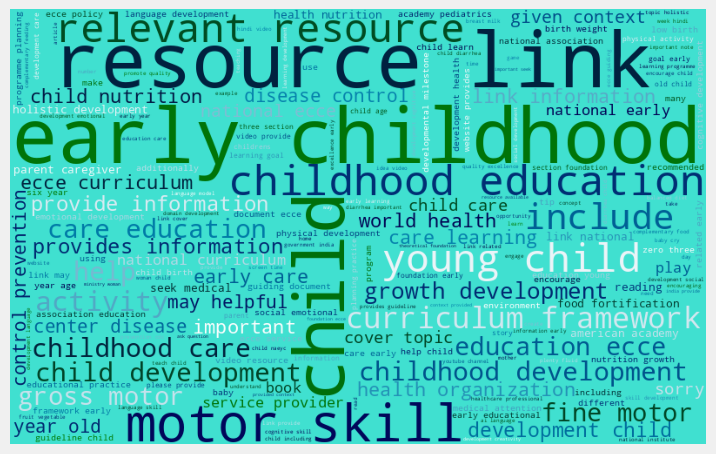

In [23]:
wc = WordCloud(width = 800, height = 500, background_color='#40E0D0', colormap="ocean",  random_state=10).generate(response_corpus)
plt.imshow(wc);
plt.axis('off')
plt.show()


# Topic Modelling

We can use either LDA or LSA

## LDA

In [24]:
#tokenize articles
tokenize_text = df.text_response.apply(lambda x : x.split())

In [25]:
# Create bigrams and trigrams
bigram = Phrases(tokenize_text, min_count=4, threshold=100)
trigram = Phrases(bigram[tokenize_text], min_count=4, threshold=100)

In [26]:
# Add bigrams and trigrams to tokenized text
tokenized_text = list(trigram[bigram[tokenize_text]])
# tokenized_text

In [27]:
id2word = corpora.Dictionary(tokenize_text)
# id2word

In [28]:
# Create Corpus
texts = tokenize_text
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [29]:
# Create TF-IDF model
tfidf = models.TfidfModel(corpus)

# Apply TF-IDF transformation to the corpus
corpus_tfidf = tfidf[corpus]

In [30]:
#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]
corpus_example[0][:50]

[('care', 1),
 ('child', 2),
 ('childhood', 1),
 ('concern', 1),
 ('country', 1),
 ('cover', 1),
 ('created', 1),
 ('curricular', 1),
 ('curriculum', 2),
 ('development', 2),
 ('document', 1),
 ('draw', 1),
 ('early', 1),
 ('ecce', 3),
 ('education', 1),
 ('educator', 1),
 ('experience', 1),
 ('expert', 1),
 ('foundation', 1),
 ('framework', 3),
 ('goal', 1),
 ('government', 1),
 ('group', 1),
 ('guiding', 1),
 ('idea', 1),
 ('including', 1),
 ('india', 1),
 ('individual', 1),
 ('issue', 1),
 ('link', 1),
 ('many', 1),
 ('ministry', 1),
 ('national', 2),
 ('objective', 1),
 ('official', 1),
 ('outline', 1),
 ('planning', 1),
 ('principle', 2),
 ('program', 1),
 ('theoretical', 1),
 ('topic', 1),
 ('woman', 1)]

In [31]:
# gensim.models.ldamodel.LdaModel?

In [32]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=8,
                                            random_state=100,
                                            alpha='symmetric',
                                            per_word_topics=True,
                                            passes=10,
                                            iterations=50
                                           )

In [33]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"information" + 0.020*"not" + 0.019*"context" + 0.018*"anganwadi" + '
  '0.017*"child" + 0.014*"resource" + 0.013*"provide" + 0.012*"sorry" + '
  '0.012*"link" + 0.012*"relevant"'),
 (1,
  '0.044*"skill" + 0.042*"motor" + 0.034*"development" + 0.022*"child" + '
  '0.016*"resource" + 0.015*"gross" + 0.013*"fine" + 0.013*"link" + '
  '0.011*"milestone" + 0.011*"developmental"'),
 (2,
  '0.055*"child" + 0.021*"activity" + 0.020*"resource" + 0.017*"video" + '
  '0.012*"link" + 0.012*"help" + 0.011*"skill" + 0.010*"provide" + '
  '0.009*"parent" + 0.009*"young"'),
 (3,
  '0.016*"resource" + 0.013*"kid" + 0.011*"link" + 0.011*"game" + '
  '0.010*"website" + 0.008*"provides" + 0.007*"ke" + 0.007*"including" + '
  '0.007*"video" + 0.006*"material"'),
 (4,
  '0.055*"food" + 0.040*"month" + 0.034*"year" + 0.021*"fortification" + '
  '0.018*"complementary" + 0.015*"feeding" + 0.015*"skill" + 0.012*"infant" + '
  '0.012*"resource" + 0.012*"health"'),
 (5,
  '0.055*"child" + 0.031*"re

In [34]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.003337  0.001764       1        1  25.577682
2      0.020843 -0.087286       2        1  21.183260
6     -0.306969 -0.049202       3        1  19.311212
1     -0.054451  0.120450       4        1  12.446845
4      0.078216  0.256776       5        1   6.717705
7      0.128555 -0.136942       6        1   5.761339
0      0.040642 -0.017677       7        1   4.850864
3      0.096500 -0.087883       8        1   4.151093, topic_info=            Term         Freq        Total Category  logprob  loglift
12         early  1129.000000  1129.000000  Default  30.0000  30.0000
14     education   702.000000   702.000000  Default  29.0000  29.0000
557         food   374.000000   374.000000  Default  28.0000  28.0000
13          ecce   413.000000   413.000000  Default  27.0000  27.0000
685        motor   362.000000   362.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
1          child    16.004386  2383.706261   Topic8  -5.0904  -1.8218
277    cognitive    11.988361   163.869676   Topic8  -5.3794   0.5667
82   information    12.847470   587.598616   Topic8  -5.3102  -0.6411
324  educational    11.683127   155.001178   Topic8  -5.4052   0.5965
38       program    11.294900   152.502853   Topic8  -5.4389   0.5790

[555 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1519      1  0.916363  abhiyaan
101       1  0.163356   ability
101       2  0.054452   ability
101       3  0.027226   ability
101       4  0.762326   ability
...     ...       ...       ...
943       2  0.782972   youtube
943       4  0.020076   youtube
943       5  0.020076   youtube
943       6  0.020076   youtube
943       8  0.140533   youtube

[1291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 2, 5, 8, 1, 4])

## Hyperparameter tuning

In [35]:
# Define a function to calculate coherence score for a given set of hyperparameters
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=n,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha=alpha,
                                                per_word_topics=True,
                                                eta=beta,
                                                iterations=50)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_text, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

n: 6; alpha: symmetric; beta: auto; Score: 0.5492500775957635
n: 6; alpha: symmetric; beta: 0.3; Score: 0.5485969257256783
n: 6; alpha: symmetric; beta: 0.5; Score: 0.5424420010972743
n: 6; alpha: symmetric; beta: 0.7; Score: 0.5538878495168587
n: 6; alpha: 0.3; beta: auto; Score: 0.5240779692774242
n: 6; alpha: 0.3; beta: 0.3; Score: 0.5696130001626379
n: 6; alpha: 0.3; beta: 0.5; Score: 0.5465711540403096
n: 6; alpha: 0.3; beta: 0.7; Score: 0.5477878775807951
n: 6; alpha: 0.5; beta: auto; Score: 0.5865311572611699
n: 6; alpha: 0.5; beta: 0.3; Score: 0.5525518257770939
n: 6; alpha: 0.5; beta: 0.5; Score: 0.5489028233087648
n: 6; alpha: 0.5; beta: 0.7; Score: 0.5463305167902179
n: 6; alpha: 0.7; beta: auto; Score: 0.5347415473075957
n: 6; alpha: 0.7; beta: 0.3; Score: 0.5383578797462426
n: 6; alpha: 0.7; beta: 0.5; Score: 0.5431095153152415
n: 6; alpha: 0.7; beta: 0.7; Score: 0.5280138557297603
n: 7; alpha: symmetric; beta: auto; Score: 0.5527173492435675
n: 7; alpha: symmetric; beta: 

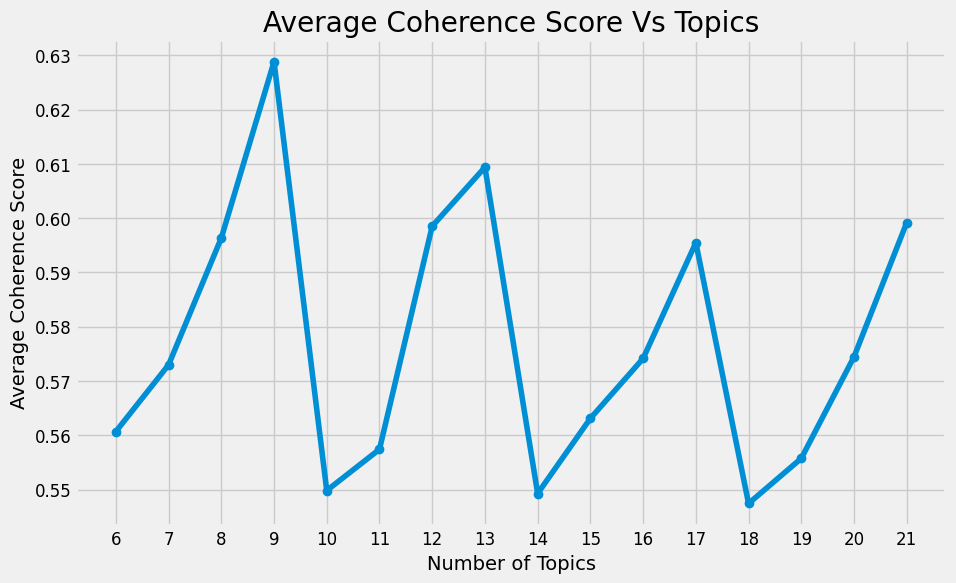

In [38]:
# List containing various hyperparameters
no_of_topics = [6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20,21]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]

# Lists to store coherence scores & hyperparameters
coherence_scores = []
hyperparameters = []

# lets loop
for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            coherence_scores.append(coherence_score)
            hyperparameters.append((n, alpha, beta))
            print(f"n: {n}; alpha: {alpha}; beta: {beta}; Score: {coherence_score}")

# Calculate average coherence score for each number of topics:
avg_coherence_per_topic = {}
for i, n in enumerate(no_of_topics):
    avg_coherence = sum(coherence_scores[i::len(no_of_topics)]) / len(alpha_list) / len(beta_list)
    avg_coherence_per_topic[n] = avg_coherence

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_coherence_per_topic.keys(), avg_coherence_per_topic.values(), marker='o')
plt.title('Average Coherence Score Vs Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.grid(True)
plt.xticks(no_of_topics)
plt.show()

n: 6; alpha: symmetric; beta: auto; Score: 0.5492500775957635


In [39]:
n = 6
alpha = 'symmetric'
beta = 'auto'
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5492500775957635


In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.055133  0.115781       1        1  36.193835
5     -0.122726  0.185156       2        1  20.675312
0     -0.284090 -0.208494       3        1  18.120173
1      0.057859  0.076568       4        1  11.795258
4      0.199469 -0.005561       5        1   9.618881
3      0.204621 -0.163449       6        1   3.596541, topic_info=              Term         Freq        Total Category  logprob  loglift
12           early  1071.000000  1071.000000  Default  30.0000  30.0000
307          skill   580.000000   580.000000  Default  29.0000  29.0000
557           food   451.000000   451.000000  Default  28.0000  28.0000
9      development  1313.000000  1313.000000  Default  27.0000  27.0000
14       education   632.000000   632.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
154   organization    14.207070   116.581553   Topic6  -5.0662   1.2203
2162      friendly    10.180910    25.983348   Topic6  -5.3994   2.3883
61        resource    15.846604  1295.031458   Topic6  -4.9569  -1.0781
26           india    11.926414   156.586329   Topic6  -5.2411   0.7503
140        academy    11.681462   134.051056   Topic6  -5.2619   0.8850

[365 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1519      5  0.989305  abhiyaan
1262      4  0.954868     abuse
140       1  0.663926   academy
140       4  0.149197   academy
140       5  0.096978   academy
...     ...       ...       ...
431       1  0.691203     young
431       2  0.120961     young
431       3  0.142561     young
431       4  0.043200     young
943       1  0.977787   youtube

[534 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 1, 2, 5, 4])

n: 11; alpha: symmetric; beta: 0.7; Score: 0.6284732415962054


In [41]:
n = 11
alpha = 'symmetric'
beta = 0.7
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6284732415962054


In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.052271  0.022664       1        1  20.489160
6      0.275899  0.146620       2        1  20.140627
5      0.090275 -0.058939       3        1  18.948732
10     0.141336 -0.183179       4        1  10.991130
7     -0.052241 -0.049841       5        1  10.114816
8     -0.048564 -0.015881       6        1   6.384680
1     -0.049307  0.007330       7        1   6.174752
9     -0.111933  0.032698       8        1   3.101180
4     -0.093506  0.032615       9        1   1.679901
3     -0.102076  0.035729      10        1   1.009328
0     -0.102153  0.030183      11        1   0.965694, topic_info=             Term         Freq        Total Category  logprob  loglift
12          early   919.000000   919.000000  Default  30.0000  30.0000
307         skill   379.000000   379.000000  Default  29.0000  29.0000
9     development  1017.000000  1017.000000  Default  28.0000  28.0000
14      education   544.000000   544.000000  Default  27.0000  27.0000
13           ecce   370.000000   370.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2913          toh     0.483891     4.842632  Topic11  -7.1309   2.3367
3329          kho     0.443723     4.853878  Topic11  -7.2176   2.2477
2846        aapka     0.419818     4.778559  Topic11  -7.2730   2.2080
139           aap     0.576412    10.592942  Topic11  -6.9559   1.7290
29           link     0.636031   636.171564  Topic11  -6.8575  -2.2679

[540 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
139       1  0.094402      aap
139       3  0.566415      aap
139       5  0.094402      aap
139       7  0.094402      aap
139      11  0.094402      aap
...     ...       ...      ...
431       7  0.015136    young
943       1  0.887817  youtube
943       3  0.022765  youtube
943       5  0.022765  youtube
943       7  0.022765  youtube

[2434 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 11, 8, 9, 2, 10, 5, 4, 1])

n: 20; alpha: symmetric; beta: 0.7; Score: 0.7333353688208897


In [43]:
n = 20
alpha = 'symmetric'
beta = 0.7
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenize_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis


Coherence Score:  0.7333353688208897


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.253416 -0.123690       1        1  22.325998
2     -0.138272 -0.079185       2        1  19.649992
16    -0.296849  0.178776       3        1  17.579980
12    -0.000605 -0.074017       4        1   9.410793
17     0.005996 -0.018230       5        1   7.887373
13    -0.005553 -0.070724       6        1   7.373231
19     0.004865 -0.016202       7        1   5.623207
18     0.064221  0.003585       8        1   2.916124
10     0.045954  0.021160       9        1   1.923054
1      0.051337  0.024496      10        1   1.557306
11     0.052436  0.017777      11        1   1.191342
0      0.057153  0.017153      12        1   0.773722
8      0.052287  0.020114      13        1   0.603019
15     0.052341  0.014727      14        1   0.328885
7      0.053172  0.014843      15        1   0.228502
9      0.050839  0.013761      16        1   0.186532
6      0.052508  0.014897      17        1   0.171168
14     0.050742  0.013973      18        1   0.128075
4      0.050422  0.013393      19        1   0.070849
3      0.050422  0.013393      20        1   0.070849, topic_info=            Term         Freq        Total Category  logprob  loglift
12         early   924.000000   924.000000  Default  30.0000  30.0000
9    development  1194.000000  1194.000000  Default  29.0000  29.0000
307        skill   379.000000   379.000000  Default  28.0000  28.0000
14     education   563.000000   563.000000  Default  27.0000  27.0000
557         food   309.000000   309.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
24          idea     0.011153    64.377390  Topic20  -8.2888  -1.4085
25     including     0.011153   203.864460  Topic20  -8.2888  -2.5611
26         india     0.011153   124.667391  Topic20  -8.2888  -2.0693
27    individual     0.011153    11.597227  Topic20  -8.2888   0.3055
28         issue     0.011153    19.674195  Topic20  -8.2888  -0.2230

[931 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2625      1  0.185141    aahar
2625      2  0.185141    aahar
2625      4  0.185141    aahar
2625      5  0.185141    aahar
139       1  0.418000      aap
...     ...       ...      ...
943       1  0.032353  youtube
943       2  0.032353  youtube
943       4  0.032353  youtube
943       5  0.032353  youtube
943       7  0.841185  youtube

[3713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 17, 13, 18, 14, 20, 19, 11, 2, 12, 1, 9, 16, 8, 10, 7, 15, 5, 4])

twenty topics are with 73 score which is really good.

In [44]:
pprint(lda_model.print_topics())

[(0,
  '0.004*"hai" + 0.004*"aur" + 0.004*"ki" + 0.003*"ke" + 0.003*"ko" + '
  '0.002*"baccho" + 0.002*"karna" + 0.002*"se" + 0.002*"hain" + 0.002*"kaise"'),
 (1,
  '0.012*"low" + 0.011*"weight" + 0.009*"birth" + 0.008*"factor" + '
  '0.006*"fetal" + 0.006*"maternal" + 0.004*"condition" + 0.004*"infection" + '
  '0.004*"hypertension" + 0.004*"india"'),
 (2,
  '0.037*"child" + 0.021*"resource" + 0.016*"activity" + 0.016*"provide" + '
  '0.012*"context" + 0.012*"information" + 0.010*"question" + 0.010*"video" + '
  '0.010*"link" + 0.010*"not"'),
 (3,
  '0.000*"knee" + 0.000*"jana" + 0.000*"jaise" + 0.000*"karna" + 0.000*"karan" '
  '+ 0.000*"kam" + 0.000*"kai" + 0.000*"khilana" + 0.000*"hote" + '
  '0.000*"hone"'),
 (4,
  '0.000*"jana" + 0.000*"isliye" + 0.000*"karna" + 0.000*"karan" + 0.000*"kam" '
  '+ 0.000*"kai" + 0.000*"khilana" + 0.000*"jaise" + 0.000*"ho" + '
  '0.000*"hote"'),
 (5,
  '0.062*"development" + 0.061*"child" + 0.041*"resource" + 0.025*"nutrition" '
  '+ 0.024*"link" +

In [45]:
def get_dominant_topic(text):
    bow = id2word.doc2bow(text.split())  # Convert text to bag-of-words
    topic_probs = lda_model.get_document_topics(bow)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    return dominant_topic

# Apply the function to each row in the DataFrame
df['topic_number'] = df['text_response'].apply(get_dominant_topic)

In [46]:
df

,chat_id,question_translated,text_response,topic_number
0,1000,ncf,national ecce curriculum framework document cr...,16
1,1014,girl diarrhoea,resource link video hindi discus major cause s...,5
2,1021,child fever,child fever important monitor temperature prov...,12
3,1022,yes,ai language model policy provide best answer p...,2
4,1023,child fever,child fever important monitor temperature prov...,12
...,...,...,...,...
922,988,ncf,national ecce curriculum framework ncf framewo...,16
923,989,raw pea paragraph,sorry not resource link specifically raw pea p...,10
924,991,national curriculum framework ece,national curriculum framework early childhood ...,16
925,993,t,relevant resource link early childhood educati...,5


In [47]:
topic_category_mapping = {
    0: "Hindi",
    1: "Health Related",
    2: "Education_resource",
    3: "Hindi",
    4: "Hindi",
    5: "Child_development",
    6: "Statistics_or_Mathematics",
    7: "Cooking",
    8: "History",
    9: "Philosophy",
    10: "Motor_Skills",
    11: "Nutrition Deficiency",
    12: "Medical_advice",
    13: "child_nutrition",
    14: "Mathematics",
    15: "summercamp",
    16: "early_child_education",
    17: "Motor_Skills",
    18: "Parenting",
    19: "Child Entertainment"
}

In [48]:
df['topic_category'] = df['topic_number'].map(topic_category_mapping)
df.to_csv('inspect.csv')

In [49]:
df

,chat_id,question_translated,text_response,topic_number,topic_category
0,1000,ncf,national ecce curriculum framework document cr...,16,early_child_education
1,1014,girl diarrhoea,resource link video hindi discus major cause s...,5,Child_development
2,1021,child fever,child fever important monitor temperature prov...,12,Medical_advice
3,1022,yes,ai language model policy provide best answer p...,2,Education_resource
4,1023,child fever,child fever important monitor temperature prov...,12,Medical_advice
...,...,...,...,...,...
922,988,ncf,national ecce curriculum framework ncf framewo...,16,early_child_education
923,989,raw pea paragraph,sorry not resource link specifically raw pea p...,10,Motor_Skills
924,991,national curriculum framework ece,national curriculum framework early childhood ...,16,early_child_education
925,993,t,relevant resource link early childhood educati...,5,Child_development


# ML Model Development for predicting the topic of the question

## Sklearn Import needed for this section

In [50]:
# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer

# model:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import f1_score,recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve

In [51]:
df2 = df.copy()

In [52]:
df2.head(3)

,chat_id,question_translated,text_response,topic_number,topic_category
0,1000,ncf,national ecce curriculum framework document cr...,16,early_child_education
1,1014,girl diarrhoea,resource link video hindi discus major cause s...,5,Child_development
2,1021,child fever,child fever important monitor temperature prov...,12,Medical_advice


In [53]:
df2.shape

(910, 5)

## Data preprocessing and cleaning

Data is already preprocessed just, lets check the nan values in question_translated

In [58]:
df2.isna().sum()

chat_id                0
question_translated    0
text_response          0
topic_number           0
topic_category         0
dtype: int64

In [60]:
df2.shape

(910, 5)

In [59]:
df2[df2.question_translated =='']

,chat_id,question_translated,text_response,topic_number,topic_category
113,1163,,keep answer short summarizing main topic cover...,5,Child_development
115,1165,,keep answer short adding relevant resource lin...,2,Education_resource
123,1174,,sorry context provided doe not relate question...,2,Education_resource
194,1586,,relevant resource link added short answer earl...,10,Motor_Skills
201,1596,,ai language model always strive provide short ...,2,Education_resource
202,1597,,keep answer short important focus directly ans...,2,Education_resource
224,1666,,relevant resource link added short answer earl...,10,Motor_Skills
242,1761,,ai language model always strive provide short ...,2,Education_resource
245,1772,,apologize confusion information provided varia...,5,Child_development
334,2005,,hello baalsakhi early childhood chatbot provid...,2,Education_resource


In [64]:
## remove the empty rows
df2 = df2[df2['question_translated'] != '']

In [63]:
## recheck:
df2[df2.question_translated =='']

,chat_id,question_translated,text_response,topic_number,topic_category


## check the dataimbalance

<Axes: xlabel='topic_number', ylabel='count'>

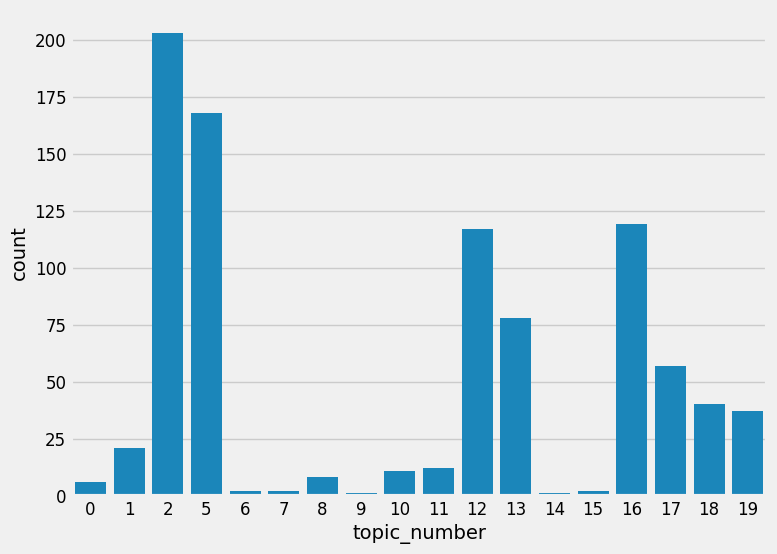

In [67]:
sns.countplot(x = df2['topic_number'])

lets keep the distribution same for now, we will look into it later and handle the imabalance

## seperate the X and Y label

In [68]:
X,y = df2['question_translated'],df2['topic_number']

In [69]:
X.shape, y.shape

((885,), (885,))

## TFIDF Vectorizer:

In [70]:
vec = TfidfVectorizer(analyzer='word',
                      ngram_range=(1,5))

In [71]:
question_translated_tfidf = vec.fit_transform(df2['question_translated'])

In [72]:
question_translated_tfidf.shape

(885, 3940)

## Handling imbalance in the dataset:

Left empty intentionally

## Train test split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(question_translated_tfidf,
                                                    y,
                                                    random_state=42,
                                                    test_size = 0.2)

In [75]:
X_train.shape,y_train.shape, X_test.shape,y_test.shape

((708, 3940), (708,), (177, 3940), (177,))

## Building Multiclass classification model

### model evaluator

In [80]:
# define the function to evaluate those models

def model_evaluator(true_label, predicted_label):
  score = f1_score(true_label,
                   predicted_label,
                   average= 'micro')
  return score

### Baseline Model

In [78]:
from sklearn.dummy import DummyClassifier
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [79]:
yTrainPred_Baseline = baseline_model.predict(X_train)
yTestPred_Baseline = baseline_model.predict(X_test)

In [81]:
model_evaluator(y_train, yTrainPred_Baseline), model_evaluator(y_test, yTestPred_Baseline)

(0.21892655367231637, 0.2711864406779661)

### Logistic Regression

In [82]:
logreg = LogisticRegression(max_iter = 100000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [83]:
yTrainPredM1 = logreg.predict(X_train)
yTestPredM1 = logreg.predict(X_test)

In [84]:
model_evaluator(y_train, yTrainPredM1), model_evaluator(y_test, yTestPredM1)

(0.806497175141243, 0.6101694915254238)

#### Hyperparameter tuning

In [93]:
param_grid_lg = {
    'C': [0.001,0.01, 0.1, 1.0,10,12],  # Inverse of regularization strength
    'penalty': [None,'l1', 'l2'],
    'solver': ['sag']
}

In [94]:
m1_logreg_HPT = LogisticRegression(max_iter = 100000)
m1_logreg_gscv = GridSearchCV(m1_logreg_HPT, param_grid_lg, cv=5, scoring='f1_micro')
m1_logreg_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=100000),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 12],
                         'penalty': [None, 'l1', 'l2'], 'solver': ['sag']},
             scoring='f1_micro')

In [95]:
m1_logreg_gscv.best_params_,m1_logreg_gscv.best_score_


({'C': 12, 'penalty': 'l2', 'solver': 'sag'}, 0.6468984117470782)

In [96]:
C_values = [0.0001,0.001,0.01,0.1,1,2,5,10,20]
train_scores = []
test_scores = []

# Perform regularization and evaluate on train and test data
for C in C_values:
    print(C)
    logreg = LogisticRegression(max_iter=100000, C=C, penalty='l2', solver='sag')
    logreg.fit(X_train, y_train)
    y_train_pred = logreg.predict(X_train)
    y_test_pred = logreg.predict(X_test)

    train_accuracy = model_evaluator(y_train, y_train_pred)
    test_accuracy = model_evaluator(y_test, y_test_pred)

    train_scores.append(train_accuracy)
    test_scores.append(test_accuracy)

0.0001
0.001
0.01
0.1
1
2
5
10
20


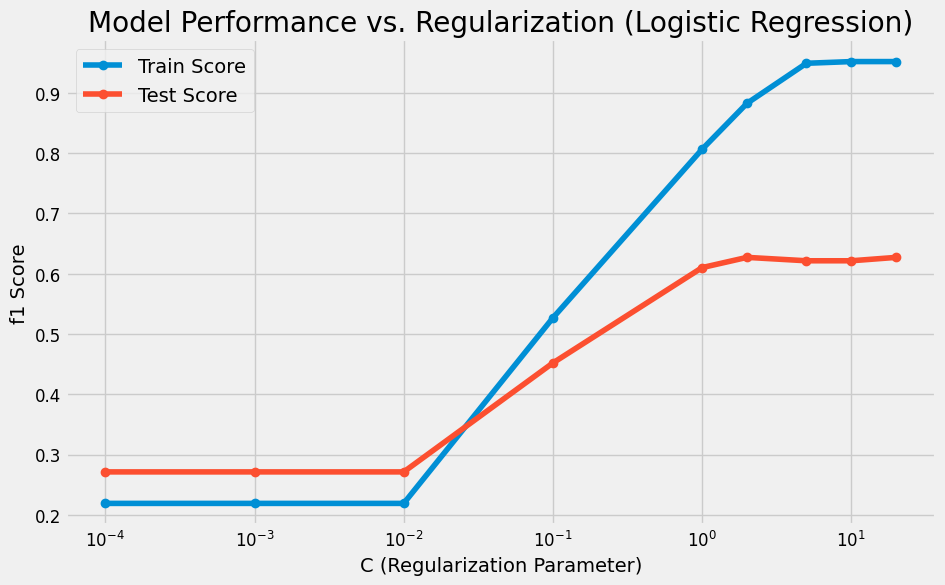

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_scores, label='Train Score', marker='o')
plt.plot(C_values, test_scores, label='Test Score', marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('f1 Score')
plt.title('Model Performance vs. Regularization (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()

In [98]:
logreg = LogisticRegression(max_iter=10000, C=1, penalty='l2', solver='sag')
logreg.fit(X_train, y_train)
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

logreg_train_accuracy = model_evaluator(y_train, y_train_pred)
logreg_test_accuracy = model_evaluator(y_test, y_test_pred)

logreg_train_accuracy, logreg_test_accuracy

(0.806497175141243, 0.6101694915254238)

In [101]:

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_test, y_test_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()

### Bagging

In [117]:
from sklearn.ensemble import BaggingClassifier

bagModel = BaggingClassifier(logreg, n_estimators=20, random_state=42)

bagModel.fit(X_train, y_train)

BaggingClassifier(estimator=LogisticRegression(C=1, max_iter=10000,
                                               solver='sag'),
                  n_estimators=20, random_state=42)

In [118]:
y_train_pred_bag = bagModel.predict(X_train)
y_test_pred_bag = bagModel.predict(X_test)

In [119]:
bag_f1_train = model_evaluator(y_train, y_train_pred_bag)
bag_f1_test = model_evaluator(y_test, y_test_pred_bag)

In [121]:
bag_f1_train,bag_f1_test

(0.8022598870056498, 0.6214689265536724)

### LinearSVC

In [102]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [103]:
yTrainPredM3 = svc.predict(X_train)
yTestPredM3 = svc.predict(X_test)

In [104]:
model_evaluator(y_train, yTrainPredM3), model_evaluator(y_test, yTestPredM3)

(0.9519774011299436, 0.6440677966101694)

#### hyperparameter tuning

In [105]:
param_grid = {
    'C': [0.001,0.01,0.1, 1.0],  # Regularization
    'loss': ['hinge'],  # Loss function
    'max_iter': [10000],
}

In [107]:
svc_HPT = LinearSVC(max_iter = 100000)
svc_gscv = GridSearchCV(svc_HPT, param_grid, cv=5, scoring='f1_micro')
svc_gscv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=100000),
             param_grid={'C': [0.001, 0.01, 0.1, 1.0], 'loss': ['hinge'],
                         'max_iter': [10000]},
             scoring='f1_micro')

In [112]:
svc_gscv.best_estimator_, svc_gscv.best_params_

(LinearSVC(loss='hinge', max_iter=10000),
 {'C': 1.0, 'loss': 'hinge', 'max_iter': 10000})

In [113]:
C_values = [0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4]

svc_train_scores = []
svc_test_scores = []

for C in C_values:
    print(C)
    svc = LinearSVC(C=C,loss = 'squared_hinge', max_iter = 10000)
    svc.fit(X_train, y_train)
    y_train_pred = svc.predict(X_train)
    y_test_pred = svc.predict(X_test)

    train_accuracy = model_evaluator(y_train, y_train_pred)
    test_accuracy = model_evaluator(y_test, y_test_pred)

    svc_train_scores.append(train_accuracy)
    svc_test_scores.append(test_accuracy)

0.01
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1
2
3
4


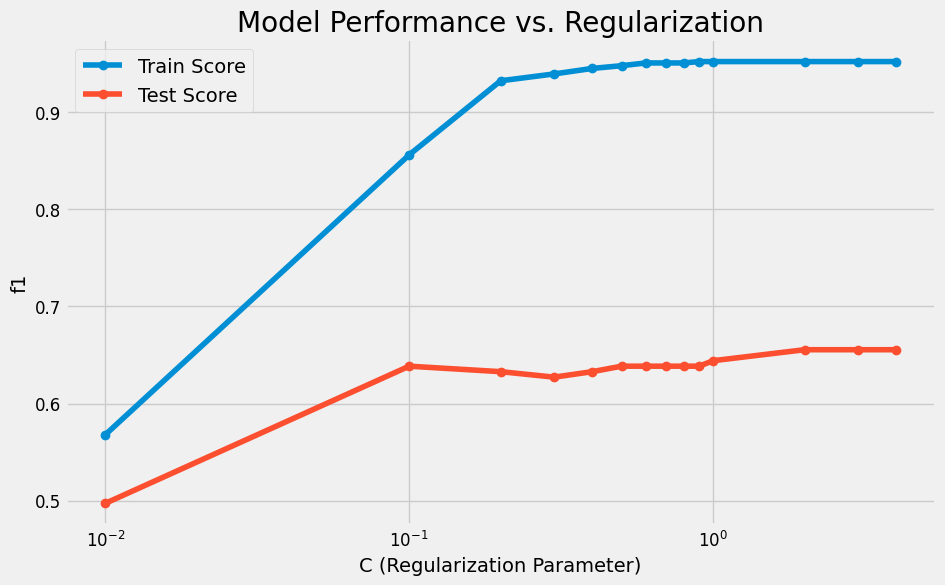

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, svc_train_scores, label='Train Score', marker='o')
plt.plot(C_values, svc_test_scores, label='Test Score', marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('f1')
plt.title('Model Performance vs. Regularization')
plt.legend()
plt.grid(True)
plt.show()

In [125]:
svc = LinearSVC(C=0.1,loss = 'squared_hinge', max_iter = 10000)
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

svc_train_accuracy = model_evaluator(y_train, y_train_pred)
svc_test_accuracy = model_evaluator(y_test, y_test_pred)

svc_train_accuracy, svc_test_accuracy

(0.8559322033898306, 0.6384180790960452)

### Results

In [126]:
model_names = ['Model 1: LogREG', 'Model 2: Bagging', 'Model 3:LinearSVC']
TrainScore = [logreg_train_accuracy, bag_f1_train, svc_train_accuracy]
TestScore = [logreg_test_accuracy, bag_f1_test, svc_test_accuracy]

In [127]:
data = {
    'Model Name': model_names,
    'Train Score': TrainScore,
    'Test Score': TestScore
}

In [128]:
results_df = pd.DataFrame(data)


In [129]:
results_df


,Model Name,Train Score,Test Score
0,Model 1: LogREG,0.806497,0.610169
1,Model 2: Bagging,0.802260,0.621469
2,Model 3:LinearSVC,0.855932,0.638418


LinearSVC model is performing better. There are alot of things that can be done- reducing the classes, handling class imbalance, using advanced deep learning models, which will considerably improve the accuracy